In [ ]:
import numpy as np
import random
import math
import nsl_request
import nsl_placement
import substrate_graphs
import copy
#import ql as qagent
#import telegram_bot as bot
import time



import numpy as np

def calculate_profit_nodes(nslr,end_simulation_time):
    #Calculates profit per time unit and then multiplies it by the nslr op. time
    #profit = revenue-cost 
    cost = 0
    revenue = 0    
    vnfs = nslr.nsl_graph_reduced["vnodes"]
    time = 0.0

    cf_cpu = 0 #cost factor of physical nodes(depends on node type)
    for vnf in vnfs:
        if vnf["type"] == 0:#central
            cf_cpu = 1
        elif vnf["type"] == 1:#edge
            cf_cpu = 3
        # else:
        #     cf_cpu = 4 
        cost += vnf["cpu"]*cf_cpu
        revenue += vnf["cpu"]*cf_cpu*2#revenue es el doble del costo (hasta ahora) 

    if nslr.end_time > end_simulation_time:
        #si es mayor, se considera la porcion de tiempo hasta acabar la simulacion  
        time = nslr.operation_time - (nslr.end_time-end_simulation_time)
    else:
        time = nslr.operation_time

    profit = (revenue-cost)*time 
    return profit

def calculate_profit_links(nslr,end_simulation_time):
    #Calculates profit per time unit and then multiplies it by the nslr op. time
    #profit = revenue-cost 
    cost = 0
    revenue = 0        
    vlinks = nslr.nsl_graph_reduced["vlinks"]    
    cf_bw =  0.5#cost factor of physical links    
    time = 0.0

    for vlink in vlinks:
        try:
            hops = len(vlink["mapped_to"])-1
        except KeyError:
            hops=0
        cost += vlink["bw"]*cf_bw*hops #cost is proportional to the number of hops
        revenue += vlink["bw"]*cf_bw*5*1.5 #(5:se cobra considerando el max num de hops permitido y 1.5: un 50% adicional al cost con 5hops)

    if nslr.end_time > end_simulation_time:
        #si es mayor, se considera la porcion de tiempo hasta acabar la simulacao  
        time = nslr.operation_time - (nslr.end_time-end_simulation_time)
    else:
        time = nslr.operation_time

    profit = (revenue-cost)*time
    return profit

def calculate_request_utilization(nslr,end_simulation_time,substrate):
    vnfs = nslr.nsl_graph_reduced["vnodes"]
    vlinks = nslr.nsl_graph_reduced["vlinks"]
    time = 0.0
    central_sum = 0
    edge_sum = 0
    bw_sum = 0 
    
    for vnf in vnfs:
        if vnf["type"] == 0:#central
            central_sum += vnf["cpu"]
        elif vnf["type"] == 1:#edge
            edge_sum += vnf["cpu"]

    for vlink in vlinks:
        bw_sum += vlink["bw"]      
        

    if nslr.end_time > end_simulation_time:
        #si es mayor, se considera la porcion de tiempo hasta acabar la simulacion  
        time = nslr.operation_time - (nslr.end_time-end_simulation_time)
    else:
        time = nslr.operation_time

    edge_utl = edge_sum*time
    central_utl = central_sum*time
    links_utl = bw_sum*time  

    return edge_utl, central_utl, links_utl

# def calculate_request_utilization(nslr,end_simulation_time,substrate):
#     '''
#         Calculates resource utilization of the current requests
#         utilization: the time the resource was busy
#         profit = revenue-cost 
#     '''
#     utl = 0 
#     vnfs = nslr.nsl_graph_reduced["vnodes"]
#     vlinks = nslr.nsl_graph_reduced["vlinks"]  
#     time = 0.0
#     central_sum = 0
#     # local_sum = 0 
#     edge_sum = 0
#     bw_sum = 0
#     # print("substrate",substrate["nodes"])
#     # print("vnfs",vnfs)
#     for vnf in vnfs:
#         # print("**+",substrate["nodes"][vnf["mapped_to"]]["type"])
#         if substrate["graph"]["nodes"][vnf["mapped_to"]]["type"] == 0:
#             central_sum += vnf["cpu"]
#         # elif substrate["nodes"][vnf["mapped_to"]]["type"] == 1:
#         #     local_sum += vnf["cpu"]
#         elif substrate["graph"]["nodes"][vnf["mapped_to"]]["type"] == 1:
#             edge_sum += vnf["cpu"]
        
#         # else:
#         #     edge_sum += vnf["cpu"]  
    
#     for vlink in vlinks:
#         bw_sum += vlink["bw"]        

#     if nslr.end_time > end_simulation_time:
#         #si es mayor, se considera la porcion de tiempo hasta acabar la simulacion  
#         time = nslr.operation_time - (nslr.end_time-end_simulation_time)
#     else:
#         time = nslr.operation_time
#     # print("**++",edge_sum)
#     edge_utl = edge_sum*time 
#     # local_utl = local_sum*time 
#     central_utl = central_sum*time
#     # print("**++",central_utl)
#     links_utl = bw_sum*time 
#     # print("**++",edge_utl)
#     return edge_utl, central_utl, links_utl



def init_q(s, a, type="zeros"):
    """
    @param s the number of states
    @param a the number of actions
    @param type random, ones or zeros for the initialization
    """
    if type == "ones":
        return np.ones((s, a))
    elif type == "random":
        return np.random.random((s, a))
    elif type == "zeros":
        return np.zeros((s, a))

def epsilon_greedy(Q, epsilon, n_actions, s, train=False):
    """
    @param Q Q values state x action -> value
    @param epsilon for exploration
    @param s number of states
    @param train if true then no random actions selected
    """
    if train or np.random.rand() < epsilon: #rand() random flotante 0-1
        action = np.argmax(Q[s, :])
    else:
        action = np.random.randint(0, n_actions)
    return action


class Qagent:
    def __init__(self, alpha, gamma, epsilon, episodes, n_states, n_actions):

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.episodes = episodes
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = init_q(n_states, n_actions, type="ones")

    def take_action(self,s,first_state):
        if first_state:
            action = epsilon_greedy(self.Q,self.epsilon,self.n_actions,s,False)
        else:
            s_=s
            action = np.argmax(self.Q[s_, :])
        return action

    def updateQ(self,reward,s,a,s_,a_,end_sate):
        Q=self.Q
        alpha = self.alpha
        gamma = self.gamma
    
        if end_sate:
            print("*** Terminal state")
            Q[s, a] += alpha * (reward - Q[s, a])

        else:
            Q[s, a] += alpha * (reward + (gamma * Q[s_, a_]) - Q[s, a])




# import bisect
#simulation parameters
# seed = 0
repetitions = 1
twindow_length = 1
embb_arrival_rate = 0
urllc_arrival_rate = 0
miot_arrival_rate = 0 
arrival_rates = [100,80,60,40,30,25,20,15,10,7,5,3,1]#[60,40,30,25,20,15,10,7,5,3,1]
mean_operation_time = 15

edge_initial = 0
centralized_initial = 0
bw_initial = 0
agente = None

#RL-specific parameters
episodes = 80
avble_edge_size = 5
avble_central_size = 5
avble_bw_size = 5
n_states = avble_edge_size*avble_central_size*avble_bw_size
# n_states = avble_edge_size*avble_central_size
#7actions
actions = [(1,1,1),(0.75,1,1),(1,1,0.75),(0.75,1,0.75),(0.75,1,0.5),(0.5,1,0.5),(0.5,1,0.25)] #list of tuples
n_actions = len(actions)

class Evento:
    def __init__(self, tipo, inicio, extra, function):
        self.tipo = tipo
        self.inicio = inicio
        self.extra = extra
        self.function = function

    def __str__(self):
        return "("+self.tipo+","+str(self.inicio)+","+str(self.extra)+")"

class Controlador:
    def __init__(self):
        #metricas
        self.total_profit = 0
        self.node_profit=0
        self.link_profit=0
        self.embb_profit = 0
        self.urllc_profit = 0
        self.miot_profit = 0
        self.edge_profit = 0
        self.central_profit = 0

        self.acpt_rate = 0
        self.embb_acpt_rate = 0
        self.urllc_acpt_rate = 0
        self.miot_acpt_rate = 0
        
        self.total_utl = 0
        self.node_utl = 0
        self.link_utl = 0
        self.edge_utl = 0
        self.central_utl = 0
        self.embb_utl = 0
        self.urllc_utl = 0
        self.miot_utl = 0

        self.simulation = Sim()
        self.substrate = {}
        self.agente = None


    def run(self):
        self.simulation.run(self)

class Sim:
    def __init__(self):
        self.eventos = []
        self.total_events = 0
        self.window_req_list = []
        self.granted_req_list = []
        self.horario = 0
        self.run_till = -1
        self.total_reqs = 0
        self.total_embb_reqs = 0
        self.total_urllc_reqs = 0
        self.total_miot_reqs = 0
        self.attended_reqs = 0
        self.accepted_reqs = 0
        self.embb_accepted_reqs = 0
        self.urllc_accepted_reqs = 0
        self.miot_accepted_reqs = 0
                   

    def set_run_till(self, t):
        self.run_till = t

    # def set_substrate(self,substrate):
    #     self.substrate = substrate

    def create_event(self, tipo, inicio, extra=None, f=None):
        if inicio<self.horario:
            print("***false")
            return False
        # else:     
        e = Evento(tipo, inicio, extra, f)
        return e

    def binary_search (self, arr, l, r, x):
        if r >= l:       
            mid = int(l + (r - l)/2)
            if arr[mid].inicio == x: 
                return mid
            elif arr[mid].inicio > x: 
                return self.binary_search(arr, l, mid-1, x) 
            else: 
                return self.binary_search(arr, mid+1, r, x)   
        else:             
            return l


    def add_event(self, evt):        
        request = {}
        #encontrar indice y adicionar evt en esa posicion
        # index = 0
        # for i in range(len(self.eventos)):
        #     if self.eventos[i].inicio > evt.inicio: 
        #         index = i 
        #         break
        #     else:
        #         index = i+1 
        index = self.binary_search(self.eventos, 0, len(self.eventos)-1, evt.inicio)
        self.eventos = self.eventos[:index] + [evt] + self.eventos[index:] 
        # self.eventos.insert(index,evt)
        # self.eventos[index:index] = [evt]

        if evt.tipo == "arrival":            
            #agregar nslrs en window list
            self.total_reqs += 1
            if evt.extra["service_type"] == "embb":
                self.total_embb_reqs += 1
            elif evt.extra["service_type"] == "urllc":
                self.total_urllc_reqs += 1
            else: #evt.extra["service_type"] == "miot":
                self.total_miot_reqs += 1

            service_type = evt.extra["service_type"]
            request = nsl_request.get_nslr(self.total_reqs,service_type,mean_operation_time)
            self.window_req_list.append(copy.deepcopy(request))

    def print_eventos(self):
        print("HORARIO: ",self.horario,"\nTotal Eventos:",len(self.eventos))
        for i in range(len(self.eventos)): 
            print(self.eventos[i].tipo,self.eventos[i].inicio, end=" > ")
        print("++list: ",len(self.window_req_list))

        print("\n")

    def get_proximo_evento(self):
        if len(self.eventos)==0:
            return None
        else:
            p = self.eventos.pop(0)
            self.horario = p.inicio
            return p

    def run(self,c):
        # self.print_eventos()
        while self.horario<self.run_till:
            self.print_eventos()
            p = self.get_proximo_evento()
            if p==None:
                return    
            p.function(c,p)
 
def aleatorio(seed):
    m = 2**34
    c = 251
    a = 4*c+1
    b=351
    rand_number = (((a*seed)+b)%m)/m
    return rand_number

def get_interarrival_time(arrival_rate):
    seed = random.randint(10000000,8000000000)#cambiar solo para cada repetición
    p = aleatorio(seed) 
    # print(p)     
    inter_arrival_time = -math.log(1.0 - p)/arrival_rate #the inverse of the CDF of Exponential(_lamnbda)
    # inter_arrival_time = float('{0:,.2f}'.format(inter_arrival_time))

    return inter_arrival_time

def filtro(window_req_list,action):
    # print("****filtrando...")
    granted_req_list = []
    for req in window_req_list:
        if (req.service_type == "embb" and req.bandera <= actions[action][0]*100) or (req.service_type == "urllc" and req.bandera <= actions[action][1]*100) or (req.service_type == "miot" and req.bandera <= actions[action][2]*100):
            # print("**agregando request...")
            granted_req_list.append(req)

    return granted_req_list

def update_resources(substrate,nslr,kill):
    
    nodes = substrate.graph["nodes"]
    links = substrate.graph["links"]   
    for vnf in nslr.nsl_graph_reduced["vnodes"]:#se recorre los nodos del grafo reducido del nslr aceptado    
        if "mapped_to" in vnf:
            n = next(n for n in nodes if (n["id"] == vnf["mapped_to"] and n["type"]==vnf["type"]) )# 
            if vnf["type"] == 0:
                tipo = "centralized_cpu"
            else:
                tipo = "edge_cpu"
            if kill: #if it is kill process, resources are free again
                
                n["cpu"] = n["cpu"] + vnf["cpu"]
                substrate.graph[tipo] += vnf["cpu"]
            else:
                
                n["cpu"] = n["cpu"] - vnf["cpu"] 
                substrate.graph[tipo] -= vnf["cpu"]
    for vlink in nslr.nsl_graph_reduced["vlinks"]:
        try:#cuando dos vnfs se instancian en un mismo nodo no hay link
            path = vlink["mapped_to"]            
        except KeyError:
            path=[]
        for i in range(len(path)-1):
            try:
                l = next(l for l in links if ( (l["source"]==path[i] and l["target"]==path[i+1]) or (l["source"]==path[i+1] and l["target"]==path[i]) ) )              
                if kill:
                    l["bw"] += vlink["bw"]
                    substrate.graph["bw"] += vlink["bw"]
                else:
                    l["bw"] -= vlink["bw"]
                    substrate.graph["bw"] -= vlink["bw"]
            except StopIteration:
                pass

def resource_allocation(cn): #cn=controller
    #hace allocation para el conjunto de nslrs capturadas en una ventana de tiempo
    #las metricas calculadas aqui corresponden a un step
     
    sim = cn.simulation
    substrate = cn.substrate
    step_embb_profit = 0 
    step_urllc_profit = 0
    step_miot_profit = 0
    step_link_profit=0
    step_node_profit=0
    step_edge_profit = 0
    step_central_profit = 0
    step_profit=0
    step_edge_cpu_utl = 0
    step_central_cpu_utl = 0
    step_links_bw_utl = 0
    step_node_utl = 0
    step_total_utl = 0
    end_simulation_time = sim.run_till
    max_node_profit = substrate.graph["max_cpu_profit"]*sim.run_till
    max_link_profit = substrate.graph["max_bw_profit"]*sim.run_till
    max_profit = max_link_profit + max_node_profit

    for req in sim.granted_req_list:
        # print("**",req.service_type,req.nsl_graph)
        sim.attended_reqs += 1        
        rejected = nsl_placement.nsl_placement(req,substrate)#mapping
        if not rejected: 
            #adicionar evento de instantiation y termination
            req.set_end_time(sim.horario+req.operation_time)
            graph = req.nsl_graph_reduced
            update_resources(substrate,req,False)#instantiation, ocupar recursos
            evt = sim.create_event(tipo="termination",inicio=req.end_time, extra=req, f=func_terminate)
            sim.add_event(evt) 

            #calculo de metricas (profit, acpt_rate, contadores)            
            sim.accepted_reqs += 1
            profit_nodes = calculate_profit_nodes(req,end_simulation_time)
            profit_links = calculate_profit_links(req,end_simulation_time)*10    
            step_profit += (profit_nodes + profit_links)/max_profit #the total profit in this step is the reward
            step_link_profit += profit_links/max_link_profit
            step_node_profit += profit_nodes/max_node_profit
            step_edge_profit = 0 #ajustar
            step_central_profit = 0#ajustar

            if req.service_type == "embb":
                sim.embb_accepted_reqs += 1
                step_embb_profit += profit_nodes/max_node_profit
            elif req.service_type == "urllc":
                sim.urllc_accepted_reqs += 1
                step_urllc_profit += profit_nodes/max_node_profit
            else:
                sim.miot_accepted_reqs += 1
                step_miot_profit += profit_nodes/max_node_profit                       
            
            a,b,c = calculate_request_utilization(req,end_simulation_time,substrate)
            step_edge_cpu_utl += a/(edge_initial*end_simulation_time)
            step_central_cpu_utl += b/(centralized_initial*end_simulation_time)
            step_links_bw_utl += c*10/(bw_initial*end_simulation_time)
            step_node_utl += (a+b)/((edge_initial+centralized_initial)*end_simulation_time)
            #step_total_utl += (a+b+(c*10))/((edge_initial+centralized_initial+bw_initial)*end_simulation_time)
            step_total_utl += (step_node_utl + step_links_bw_utl)/2
             
    return step_profit,step_node_profit,step_link_profit,step_embb_profit,step_urllc_profit,step_miot_profit,step_total_utl,step_node_utl,step_links_bw_utl,step_edge_cpu_utl,step_central_cpu_utl

def get_code(value):   
    cod = 0
    value = value*100
    #para granularidad de 5 (100/5) -> (20,40,60,80,100)
    if value <= 20:
        cod = 0
    elif value <= 40:
        cod = 1
    elif value <= 60:
        cod = 2
    elif value <= 80:
        cod = 3    
    else:
        cod = 4
    return cod

def translateStateToIndex(state):
    '''
    returns state index from a given state code
    '''
    cod_avble_edge = state[0]
    cod_avble_central = state[1]
    cod_avble_bw = state[2]  
    index = cod_avble_edge*avble_central_size*avble_bw_size + cod_avble_central*avble_bw_size + cod_avble_bw
    # index = cod_avble_edge*avble_central_size + cod_avble_central
    return int(index)

def get_state(substrate):    
    cod_avble_edge = get_code(substrate.graph["edge_cpu"]/edge_initial)
    cod_avble_central = get_code(substrate.graph["centralized_cpu"]/centralized_initial)
    cod_avble_bw = get_code(substrate.graph["bw"]/bw_initial)
    state = [cod_avble_edge,cod_avble_central,cod_avble_bw]
    return state

def func_arrival(c,evt): #NSL arrival
    s = c.simulation
    # print("**/",evt.extra["arrival_rate"])
    arrival_rate = evt.extra["arrival_rate"]
    service_type = evt.extra["service_type"]
    inter_arrival_time = get_interarrival_time(arrival_rate)
    s.add_event(s.create_event(tipo="arrival",inicio=s.horario+inter_arrival_time, extra={"service_type":service_type,"arrival_rate":arrival_rate}, f=func_arrival))

# def func_criar(c,evt): #NSL instantiation
#     s = c.simulation
#     req = evt.extra

contador_termination = 0
def func_terminate(c,evt):
    global contador_termination
    contador_termination +=1
    print("terminating")
    request = evt.extra
    update_resources(c.substrate,request,True)

contador_windows = 0
def func_twindow(c,evt):
    #la venta de tiempo ha expirado. Las nslrs recolectadas hasta ahora seran analizadas para su admision
    global contador_windows
    sim = c.simulation 
    contador_windows += 1

    sim.granted_req_list = sim.window_req_list #descomentar para NR y AAR

    #la lista se envia al modulo de Resource Allocation
    step_profit,step_node_profit,step_link_profit,step_embb_profit,step_urllc_profit,step_miot_profit,step_total_utl,step_node_utl,step_links_bw_utl,step_edge_cpu_utl,step_central_cpu_utl = resource_allocation(c)
    c.total_profit += step_profit
    c.node_profit += step_node_profit
    c.link_profit += step_link_profit
    c.embb_profit += step_embb_profit
    c.urllc_profit += step_urllc_profit
    c.miot_profit += step_miot_profit
    c.total_utl += step_total_utl
    c.node_utl += step_node_utl 
    c.edge_utl += step_edge_cpu_utl 
    c.central_utl += step_central_cpu_utl
    c.link_utl += step_links_bw_utl
    
    evt = sim.create_event(tipo="twindow_end",inicio=sim.horario+twindow_length, extra={"first_state":False}, f=func_twindow)
    
    sim.add_event(evt)
    sim.window_req_list = []
    sim.granted_req_list = [] 
  
def prepare_sim(s):
    evt = s.create_event(tipo="arrival",inicio=s.horario+get_interarrival_time(embb_arrival_rate),extra={"service_type":"embb","arrival_rate":embb_arrival_rate},f=func_arrival)
    s.add_event(evt)
    evt = s.create_event(tipo="arrival",inicio=s.horario+get_interarrival_time(urllc_arrival_rate),extra={"service_type":"urllc","arrival_rate":urllc_arrival_rate},f=func_arrival)
    s.add_event(evt)
    evt = s.create_event(tipo="arrival",inicio=s.horario+get_interarrival_time(miot_arrival_rate),extra={"service_type":"miot","arrival_rate":miot_arrival_rate},f=func_arrival)
    s.add_event(evt)

    evt = s.create_event(tipo="twindow_end",inicio=s.horario+twindow_length,extra={"first_state":True,"end_state":False},f=func_twindow)
    s.add_event(evt)


                                              
# ▀████▄     ▄███▀     ██     ▀████▀███▄   ▀███▀
#   ████    ████      ▄██▄      ██   ███▄    █  
#   █ ██   ▄█ ██     ▄█▀██▄     ██   █ ███   █  
#   █  ██  █▀ ██    ▄█  ▀██     ██   █  ▀██▄ █  
#   █  ██▄█▀  ██    ████████    ██   █   ▀██▄█  
#   █  ▀██▀   ██   █▀      ██   ██   █     ███  
# ▄███▄ ▀▀  ▄████▄███▄   ▄████▄████▄███▄    ██ 
                                                                                  
def main():
    
    global edge_initial
    global centralized_initial
    global bw_initial
    global agente
    global embb_arrival_rate
    global urllc_arrival_rate
    global miot_arrival_rate
    
    for m in arrival_rates:
        embb_arrival_rate = m/3
        urllc_arrival_rate = m/3
        miot_arrival_rate = m/3
    
        total_profit_rep = []
        link_profit_rep = []
        node_profit_rep = []
        edge_profit_rep = []
        central_profit_rep = []
        profit_embb_rep = []
        profit_urllc_rep = []
        profit_miot_rep = []
        
        acpt_rate_rep = []
        acpt_rate_embb_rep = []
        acpt_rate_urllc_rep = []
        acpt_rate_miot_rep = []

        total_utl_rep = []
        link_utl_rep = []
        node_utl_rep = []
        edge_ult_rep = []
        central_utl_rep = []
        embb_utl_rep = []
        urllc_utl_rep = []
        miot_utl_rep = []    
        
        for i in range(episodes):
            total_profit_rep.append([])
            link_profit_rep.append([])
            node_profit_rep.append([])
            edge_profit_rep.append([])
            central_profit_rep.append([])
            profit_embb_rep.append([])
            profit_urllc_rep.append([])
            profit_miot_rep.append([])
            
            acpt_rate_rep.append([])
            acpt_rate_embb_rep.append([])
            acpt_rate_urllc_rep.append([])
            acpt_rate_miot_rep.append([])

            total_utl_rep.append([])
            link_utl_rep.append([])
            node_utl_rep.append([])
            edge_ult_rep.append([])
            central_utl_rep.append([])
            embb_utl_rep.append([])
            urllc_utl_rep.append([])
            miot_utl_rep.append([])
    
    
        for i in range(repetitions):
            
            agente = Qagent(0.9, 0.9, 0.9, 1, n_states, n_actions) #alpha, gamma, epsilon, episodes, n_states, n_actions

            for j in range(agente.episodes):
                print("\n","episode:",j,"\n")
                controller = None
                controller = Controlador()                   
                controller.substrate = copy.deepcopy(substrate_graphs.get_graph("64node_BA"))#get substrate    
                controller.substrate = copy.deepcopy(substrate_graphs.get_graph("abilene"))
                edge_initial = controller.substrate.graph["edge_cpu"]
                centralized_initial = controller.substrate.graph["centralized_cpu"]
                bw_initial = controller.substrate.graph["bw"]
                controller.simulation.set_run_till(15)  
                prepare_sim(controller.simulation)            
                controller.run()        

                total_profit_rep[j].append(controller.total_profit)
                node_profit_rep[j].append(controller.node_profit)        
                link_profit_rep[j].append(controller.link_profit)
                edge_profit_rep[j].append(controller.edge_profit)
                central_profit_rep[j].append(controller.central_profit)
                profit_embb_rep[j].append(controller.embb_profit)
                profit_urllc_rep[j].append(controller.urllc_profit)
                profit_miot_rep[j].append(controller.miot_profit)
                        
                acpt_rate_rep[j].append(controller.simulation.accepted_reqs/controller.simulation.total_reqs)
                acpt_rate_embb_rep[j].append(controller.simulation.embb_accepted_reqs/controller.simulation.total_embb_reqs)
                acpt_rate_urllc_rep[j].append(controller.simulation.urllc_accepted_reqs/controller.simulation.total_urllc_reqs)
                acpt_rate_miot_rep[j].append(controller.simulation.miot_accepted_reqs/controller.simulation.total_miot_reqs)
                
                total_utl_rep[j].append(controller.total_utl)
                link_utl_rep[j].append(controller.link_utl)
                node_utl_rep[j].append(controller.node_utl)
                edge_ult_rep[j].append(controller.edge_utl)
                central_utl_rep[j].append(controller.central_utl) 
                embb_utl_rep[j].append(controller.embb_utl)
                urllc_utl_rep[j].append(controller.urllc_utl)
                miot_utl_rep[j].append(controller.miot_utl)

           
            print("len",len(controller.simulation.window_req_list))    
            print("total profit: ", controller.total_profit)
            print("node_profit: ", controller.node_profit)
            print("link_profit: ", controller.link_profit)
            print("embb_profit",controller.embb_profit)
            print("urllc_profit",controller.urllc_profit)
            print("miot_profit",controller.miot_profit)
            print("total_reqs: ", controller.simulation.total_reqs)
            print("attended_reqs: ", controller.simulation.attended_reqs)
            print("accepted_reqs: ", controller.simulation.accepted_reqs)
            print("acceptance_rate: ", controller.simulation.accepted_reqs/controller.simulation.total_reqs)
            print("accepted_embb_reqs: ", controller.simulation.embb_accepted_reqs)
            print("accepted_urllc_reqs: ", controller.simulation.urllc_accepted_reqs)
            print("accepted_miot_reqs: ", controller.simulation.miot_accepted_reqs)




if __name__ == '__main__':
    #bot.sendMessage("Simulation starts!")
    start = time.time()
    main()
    end = time.time()
    #bot.sendMessage("Simulation finishes!")
    #bot.sendMessage("total time: " + str(end-start))


#print("total_node_utl: ", controller.total_node_utl)
#print("edge_node_utl: ", controller.edge_node_utl)
# print("central_node_utl: ", controller.central_node_utl)
# print("contador_termination:", contador_termination)

import numpy as np
import nsl_request
import pandas as pd

from river import compose
from river import linear_model
from river import preprocessing
from river import linear_model, naive_bayes, tree, neural_net, neighbors, ensemble




  

    

In [ ]:
df=pd.DataFrame()
from sklearn.metrics import accuracy_score
def compute_accuracy(data, model, truth_col):
    predict_all = data.apply(lambda row: model.predict_one(row), axis=1)
    acc_scores.append(accuracy_score(np.array(predict_all),data[truth_col]))
    print('Accuracy is ', acc_scores[-1])
    


acc_scores = []


total_profit_rep = []
link_profit_rep = []
node_profit_rep = []
edge_profit_rep = []
central_profit_rep = []
profit_embb_rep = []
profit_urllc_rep = []
profit_miot_rep = []

acpt_rate_rep = []
acpt_rate_embb_rep = []
acpt_rate_urllc_rep = []
acpt_rate_miot_rep = []

total_utl_rep = []
link_utl_rep = []
node_utl_rep = []
edge_ult_rep = []
central_utl_rep = []
embb_utl_rep = []
urllc_utl_rep = []
miot_utl_rep = []
for m in arrival_rates:
    embb_arrival_rate = m/3
    urllc_arrival_rate = m/3
    miot_arrival_rate = m/3

    total_profit_rep = []
    link_profit_rep = []
    node_profit_rep = []
    edge_profit_rep = []
    central_profit_rep = []
    profit_embb_rep = []
    profit_urllc_rep = []
    profit_miot_rep = []

    acpt_rate_rep = []
    acpt_rate_embb_rep = []
    acpt_rate_urllc_rep = []
    acpt_rate_miot_rep = []

    total_utl_rep = []
    link_utl_rep = []
    node_utl_rep = []
    edge_ult_rep = []
    central_utl_rep = []
    embb_utl_rep = []
    urllc_utl_rep = []
    miot_utl_rep = []    
    for i in range(100):
        total_profit_rep.append([])
        link_profit_rep.append([])
        node_profit_rep.append([])
        edge_profit_rep.append([])
        central_profit_rep.append([])
        profit_embb_rep.append([])
        profit_urllc_rep.append([])
        profit_miot_rep.append([])

        acpt_rate_rep.append([])
        acpt_rate_embb_rep.append([])
        acpt_rate_urllc_rep.append([])
        acpt_rate_miot_rep.append([])

        total_utl_rep.append([])
        link_utl_rep.append([])
        node_utl_rep.append([])
        edge_ult_rep.append([])
        central_utl_rep.append([])
        embb_utl_rep.append([])
        urllc_utl_rep.append([])
        miot_utl_rep.append([])
        Bandera=[]
        EndTime=[]
        ID=[]
        OPtime=[]
        SrvType=[]
        cpu_in=[]
        cpu_out=[]
        Admission=[]
        RQ=[]
        df1=pd.DataFrame()
        rr=np.random.randint(0,3)
        rt=['embb','urllc','miot']


        controller = None
        controller = Controlador()                   
        controller.substrate = copy.deepcopy(substrate_graphs.get_graph("64node_BA"))#get substrate    
        controller.substrate = copy.deepcopy(substrate_graphs.get_graph("abilene"))
        edge_initial = controller.substrate.graph["edge_cpu"]
        centralized_initial = controller.substrate.graph["centralized_cpu"]
        bw_initial = controller.substrate.graph["bw"]
        controller.simulation.set_run_till(15)  
        prepare_sim(controller.simulation)            
        controller.run()    


        total_profit_rep[i].append(controller.total_profit)
        node_profit_rep[i].append(controller.node_profit)        
        link_profit_rep[i].append(controller.link_profit)
        edge_profit_rep[i].append(controller.edge_profit)
        central_profit_rep[i].append(controller.central_profit)
        profit_embb_rep[i].append(controller.embb_profit)
        profit_urllc_rep[i].append(controller.urllc_profit)
        profit_miot_rep[i].append(controller.miot_profit)

        acpt_rate_rep[i].append((controller.simulation.accepted_reqs/controller.simulation.total_reqs))
        acpt_rate_embb_rep[i].append(controller.simulation.embb_accepted_reqs/controller.simulation.total_embb_reqs)
        acpt_rate_urllc_rep[i].append(controller.simulation.urllc_accepted_reqs/controller.simulation.total_urllc_reqs)
        acpt_rate_miot_rep[i].append(controller.simulation.miot_accepted_reqs/controller.simulation.total_miot_reqs)

        total_utl_rep[i].append(controller.total_utl)
        link_utl_rep[i].append(controller.link_utl)
        node_utl_rep[i].append(controller.node_utl)
        edge_ult_rep[i].append(controller.edge_utl)
        central_utl_rep[i].append(controller.central_utl) 
        embb_utl_rep[i].append(controller.embb_utl)
        urllc_utl_rep[i].append(controller.urllc_utl)
        miot_utl_rep[i].append(controller.miot_utl)


        req = nsl_request.get_nslr(i,rt[rr],15)
        RQ.append(req.nsl_graph)

        Bandera.append(req.bandera)
        EndTime.append(req.end_time)
        ID.append(req.id)
        OPtime.append(req.operation_time)

        if rt[rr]=='embb':
            SrvType.append(1)
        elif rt[rr]=='urllc':
            SrvType.append(2)
        else:
            SrvType.append(3)



        cn=controller
        sim = cn.simulation
        substrate = cn.substrate
        end_simulation_time = sim.run_till
        max_node_profit = substrate.graph["max_cpu_profit"]*sim.run_till
        max_link_profit = substrate.graph["max_bw_profit"]*sim.run_till
        max_profit = max_link_profit + max_node_profit


        evt = sim.create_event(tipo="twindow_end",inicio=sim.horario+twindow_length, extra={"first_state":False}, f=func_twindow)

        sim.add_event(evt)
        sim.window_req_list = []
        sim.granted_req_list = [] 

        if (req.service_type == "embb" and req.bandera <= 100*.5) or (req.service_type == "urllc" and req.bandera <= 100*.5) or (req.service_type == "miot" and req.bandera <= 100*.01):
            rejected = nsl_placement.nsl_placement(req,substrate)#mapping
            if rejected:
                Admission.append(0)
            else:
                Admission.append(1)
        else:

            Admission.append(0)

        df1['Bandera']=Bandera
        df1['EndTime']=EndTime
        df1['ID']=ID
        df1['OperationTime']=OPtime
        df1['ServiceType']=SrvType

        #df1['cpu_in']=list(req.nsl_graph_reduced['vnodes'][0].values())[2]
        #df1['cpu_out']=list(req.nsl_graph_reduced['vnodes'][1].values())[2]
        #df1['mapped_in']=list(req.nsl_graph_reduced['vnodes'][0].values())[4]
        #df1['mapped_out']=list(req.nsl_graph_reduced['vnodes'][1].values())[4]
        #df1['source']=list(req.nsl_graph_reduced['vlinks'][0].values())[0]
        #df1['target']=list(req.nsl_graph_reduced['vlinks'][0].values())[1]
        #df1['BW']=list(req.nsl_graph_reduced['vlinks'][0].values())[2]

        if SrvType=='embb':
            df1['x1']=controller.embb_profit
        elif SrvType=='urllc':
            df1['x1']=controller.urllc_profit
        else:
            df1['x1']=controller.miot_profit

        df1['x2']=controller.simulation.accepted_reqs/controller.simulation.total_reqs
        df1['x3']=controller.link_profit
        df1['x4']=controller.central_profit
        df1['x5']=controller.edge_profit
        df1['x6']=controller.node_profit
        df1['Admission']=Admission
        df=df.append(df1)


        cols_x = ['Bandera', 'OperationTime','ServiceType','x1','x3','x6']

        def data_feed(df_datafeed):
            # Generator function to give the next candidate
            for _ctr in range(len(df_datafeed)):
                yield df_datafeed.iloc[_ctr]


        river_model = compose.Pipeline(
            preprocessing.StandardScaler(),
            tree.HoeffdingTreeClassifier()
        )

        from sklearn.metrics import accuracy_score
    f = open("this"+str(m)+".txt","w+")
    #f = open("aar_"+str(m)+"_64BA_3de5sta_7act_80epi.txt","w+")
    #f = open("nr_"+str(m)+"_16BA_3de5sta_7act_80epi.txt","w+")
    #f = open("aar_"+str(m)+"_abilene.txt","w+")
    f.write("Repetition: "+str(i)+"\n")

    f.write("**Reward:\n")
    f.write(str(total_profit_rep)+"\n\n")
    f.write("**node_profit_rep:\n")
    f.write(str(node_profit_rep)+"\n\n")
    f.write("**link_profit_rep:\n")
    f.write(str(link_profit_rep)+"\n\n")
    f.write("**edge_profit_rep:\n")
    f.write(str(edge_profit_rep)+"\n\n")
    f.write("**central_profit_rep:\n")
    f.write(str(central_profit_rep)+"\n\n")
    f.write("**profit_embb_rep:\n")
    f.write(str(profit_embb_rep)+"\n\n")
    f.write("**profit_urllc_rep:\n")
    f.write(str(profit_urllc_rep)+"\n\n")
    f.write("**profit_miot_rep:\n")
    f.write(str(profit_miot_rep)+"\n\n")

    f.write("**Acceptance Rate:\n")
    f.write(str(acpt_rate_rep)+"\n\n")
    f.write("**acpt_rate_embb_rep:\n")
    f.write(str(acpt_rate_embb_rep)+"\n\n")
    f.write("**acpt_rate_urllc_rep:\n")
    f.write(str(acpt_rate_urllc_rep)+"\n\n")
    f.write("**acpt_rate_miot_rep:\n")
    f.write(str(acpt_rate_miot_rep)+"\n\n")

    f.write("**total_utl_rep:\n")
    f.write(str(total_utl_rep)+"\n\n")
    f.write("**node_utl_rep:\n")
    f.write(str(node_utl_rep)+"\n\n")
    f.write("**link_utl_rep:\n")
    f.write(str(link_utl_rep)+"\n\n")
    f.write("**edge_ult_rep:\n")
    f.write(str(edge_ult_rep)+"\n\n")
    f.write("**central_utl_rep:\n")
    f.write(str(central_utl_rep)+"\n\n")
    f.write("**embb_utl_rep:\n")
    f.write(str(embb_utl_rep)+"\n\n")
    f.write("**urllc_utl_rep:\n")
    f.write(str(urllc_utl_rep)+"\n\n")
    f.write("**miot_utl_rep:\n")
    f.write(str(miot_utl_rep)+"\n\n")        
    f.close()
    
nn=[]    
data_stream = data_feed(df)
for n in range(len(df)):
    data_point = next(data_stream)
    print(data_point)
    if(n>1):
        predict_one = river_model.predict_one(data_point[cols_x])
        print('Current_prediction', predict_one, data_point['Admission'])

    river_model.learn_one(data_point[cols_x],data_point['Admission'])

    compute_accuracy(df, river_model, 'Admission')
    print('------------------------')
    
    
    
    
    
    #data_point = next(data_stream)

    '''predict_one = river_model.predict_one(data_point[cols_x])
    print('Current_prediction', predict_one, data_point['Admission'])

    river_model.learn_one(data_point[cols_x],data_point['Admission'])

    compute_accuracy(df, river_model, 'Admission')
    print('------------------------')'''
    

h=np.linspace(1,len(df),len(df))

In [ ]:
acpt_rate_rep

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc_scores)

In [ ]:
plt.plot(h,df['x2'])

In [ ]:
plt.plot(h,df['x3'])

In [ ]:
h

In [ ]:
req.nsl_graph

In [ ]:
plt.plot(h,acpt_rate_embb_rep)

In [ ]:
plt.plot(h,acpt_rate_rep)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
with open('this100.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
   

In [ ]:
with open('this100.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
   
aa=[]
a=pd.DataFrame(all_data)
for i in range(len(a)):
    if a[0][i]=='**node_utl_rep:':
        aa.append(i)

In [ ]:
with open('this100.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
   
aa=[]
a=pd.DataFrame(all_data)
for i in range(len(a)):
    if a[0][i]=='**node_utl_rep:':
        aa.append(i)
acptrate=a[0][aa[0]+1]
len(acptrate)
x=np.linspace(1,len(df),len(df))

In [ ]:

dt=[]
xx=acptrate.split(',')
for i in range(1,len(xx)):
    xxx=xx[i].split(']')
    xxxx=xxx[0].split('[')
    dt.append(float(xxxx[1]))
dt.append(dt[-1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


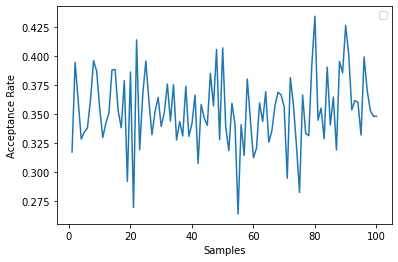

In [5]:
with open('this100.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
   
aa=[]
a=pd.DataFrame(all_data)
for i in range(len(a)):
    if a[0][i]=='**node_utl_rep:':
        aa.append(i)
acptrate=a[0][aa[0]+1]
len(acptrate)
x=np.linspace(1,len(df),len(df))
dt=[]
xx=acptrate.split(',')
for i in range(1,len(xx)):
    xxx=xx[i].split(']')
    xxxx=xxx[0].split('[')
    dt.append(float(xxxx[1]))
dt.append(dt[-1])
plt.plot(x,dt)
plt.xlabel('Samples')
plt.ylabel('Acceptance Rate')
plt.legend()
plt.savefig('acpt_rate.jpg')

In [ ]:
dt

In [ ]:
len(x)